# SCohenLab 2D BATCH Image Processing notebook (Simplified MCZ)

--------------
# PIPELINE OVERVIEW
## ❶ GOAL SETTING ✍

### GOAL:  Infer sub-cellular components in order to understand interactome 

To measure shape, position, size, and interaction of eight organelles/cellular components (Nuclei (NU), Lysosomes (LS),Mitochondria (MT), Golgi (GL), Peroxisomes (PO), Endoplasmic Reticulum (ER), Lipid Droplet (LD), and SOMA) during differentiation of iPSCs, in order to understand the Interactome / Spatiotemporal coordination.

### summary of _OBJECTIVES_ ✅
- robust inference of subcellular objects:
  + 1️⃣-***nuclei***
  + 2️⃣-***cellmask***
  + 3️⃣-***cytosol***
  + 4️⃣-***lysosome***
  + 5️⃣-***mitochondria***
  + 6️⃣-***golgi***
  + 7️⃣-***peroxisome***
  + 8️⃣-***ER***
  + 9️⃣-***lipid droplet***





## ❷ DATA CREATION
> METHODS:📚📚
> 
> iPSC lines prepared and visualized on Zeiss Microscopes. 32 channel multispectral images collected.  Linear Unmixing in  ZEN Blue software with target emission spectra yields 8 channel image outputs.  Channels correspond to: Nuclei (NU), Lysosomes (LS),Mitochondria (MT), Golgi (GL), Peroxisomes (PO), Endoplasmic Reticulum (ER), Lipid Droplet (LD), and a “residual” signal.

> Meta-DATA 🏺 (artifacts)
>   - Microcope settings
>  - OME scheme
> - Experimenter observations
> - Sample, bio-replicate, image numbers, condition values, etc
>  - Dates
>  - File structure, naming conventions
>  - etc.





## ❸. IMAGE PROCESSING ⚙️🩻🔬
### INFERENCE OF SUB-CELLULAR OBJECTS
The imported images have already been pre-processed to transform the 32 channel spectral measuremnts into "linearly unmixed" images which estimate independently labeled sub-cellular components.  Thes 7 channels (plus a residual "non-linear" signal) will be used to infer the shapes and extents of these sub-cellular components.   
We will perform computational image analysis on the pictures (in 2D an 3D) to _segment_ the components of interest for measurement.  In other prcoedures we can used these labels as "ground truth" labels to train machine learning models to automatically perform the inference of these objects.
Pseudo-independent processing of the imported multi-channel image to acheive each of the 9 objecives stated above.  i.e. infering: NUCLEI, SOMA, CYTOSOL, LYSOSOME, MITOCHONDRIA, GOLGI COMPLEX, PEROZISOMES, ENDOPLASMIC RETICULUM, and LIPID BODIES

### General flow for infering objects via segmentation
- Pre-processing 🌒
- Core-processing (thresholding) 🌕
- Post-processing  🌘

### QC 🚧 WIP 🚧 




## ❹. QUANTIFICATION 📏📐🧮

SUBCELLULAR COMPONENT METRICS
-  extent 
-  size
-  shape
-  position



### NOTE: PIPELINE TOOL AND DESIGN CHOICES?
We want to leverage the Allen Cell & Structure Setmenter.  It has been wrapped as a [napari-plugin](https://www.napari-hub.org/plugins/napari-allencell-segmenter) but fore the workflow we are proving out here we will want to call the `aicssegmentation` [package](https://github.com/AllenCell/aics-segmentation) directly.

#### ​The Allen Cell & Structure Segmenter 
​The Allen Cell & Structure Segmenter is a Python-based open source toolkit developed at the Allen Institute for Cell Science for 3D segmentation of intracellular structures in fluorescence microscope images. This toolkit brings together classic image segmentation and iterative deep learning workflows first to generate initial high-quality 3D intracellular structure segmentations and then to easily curate these results to generate the ground truths for building robust and accurate deep learning models. The toolkit takes advantage of the high replicate 3D live cell image data collected at the Allen Institute for Cell Science of over 30 endogenous fluorescently tagged human induced pluripotent stem cell (hiPSC) lines. Each cell line represents a different intracellular structure with one or more distinct localization patterns within undifferentiated hiPS cells and hiPSC-derived cardiomyocytes.

More details about Segmenter can be found at https://allencell.org/segmenter
In order to leverage the A




## IMPORTS

In [2]:
# top level imports
from pathlib import Path
import os, sys
from collections import defaultdict

import numpy as np
import scipy

# TODO:  prune the imports.. this is the big set for almost all organelles
# # function for core algorithm
from scipy import ndimage as ndi
from scipy.ndimage import median_filter
import aicssegmentation
from aicssegmentation.core.seg_dot import dot_3d_wrapper, dot_slice_by_slice, dot_2d_slice_by_slice_wrapper, dot_3d
from aicssegmentation.core.pre_processing_utils import ( intensity_normalization, 
                                                         image_smoothing_gaussian_3d,  
                                                         image_smoothing_gaussian_slice_by_slice, edge_preserving_smoothing_3d )
from aicssegmentation.core.utils import topology_preserving_thinning, size_filter
from aicssegmentation.core.MO_threshold import MO
from aicssegmentation.core.utils import hole_filling
from aicssegmentation.core.vessel import filament_2d_wrapper, vesselnessSliceBySlice
from aicssegmentation.core.output_utils import   save_segmentation,  generate_segmentation_contour
                                                 
from skimage import filters
from skimage.segmentation import watershed
from skimage.feature import peak_local_max
from skimage.morphology import remove_small_objects, binary_closing, ball , dilation, remove_small_holes   # function for post-processing (size filter)
from skimage.measure import label

# # package for io 
from aicsimageio import AICSImage

import napari

### import local python functions in ../infer_subc_2d
sys.path.append(os.path.abspath((os.path.join(os.getcwd(), '..'))))

from infer_subc_2d.core.file_io import (read_czi_image, 
                                                                    list_image_files, 
                                                                    export_ome_tiff)

from infer_subc_2d.constants import (TEST_IMG_N,
                                                                    NUC_CH ,
                                                                    LYSO_CH ,
                                                                    MITO_CH ,
                                                                    GOLGI_CH ,
                                                                    PEROX_CH ,
                                                                    ER_CH ,
                                                                    LD_CH ,
                                                                    RESIDUAL_CH )

from infer_subc_2d.core.img import *
from infer_subc_2d.organelles import *

%load_ext autoreload
%autoreload 2

test_img_n = TEST_IMG_N


## SETUP

In [3]:
# build the datapath
# all the imaging data goes here.
data_root_path = Path(os.path.expanduser("~")) / "Projects/Imaging/data"

# linearly unmixed ".czi" files are here
data_path = data_root_path / "raw"
im_type = ".czi"

# get the list of all files
img_file_list = list_image_files(data_path,im_type)
test_img_name = img_file_list[test_img_n]


In [4]:
img_data,meta_dict = read_czi_image(test_img_name)

# get some top-level info about the RAW data
channel_names = meta_dict['name']
img = meta_dict['metadata']['aicsimage']
scale = meta_dict['scale']
channel_axis = meta_dict['channel_axis']


/opt/anaconda3/envs/napariNEW/lib/python3.9/site-packages/ome_types/_convenience.py:106: FutureWarning: The default XML parser will be changing from 'xmlschema' to 'lxml' in version 0.4.0.  To silence this warning, please provide the `parser` argument, specifying either 'lxml' (to opt into the new behavior), or'xmlschema' (to retain the old behavior).
  d = to_dict(os.fspath(xml), parser=parser, validate=validate)


## CHOOZE Z-SLICE

Lets find the slice with the most overall intensity...

In [13]:
ch_to_agg = ( LYSO_CH ,
                        MITO_CH ,
                        GOLGI_CH ,
                        PEROX_CH ,
                        ER_CH ,
                        LD_CH )
                            
nuc_ch = NUC_CH
img_2D = fixed_get_optimal_Z_image(img_data)
# img_2D = img_data

choosing _optimal_ z-slice::: 8


Now get the single "optimal" slice of all our organelle channels....

## get the inferred cellmask, nuclei and cytosol objects

(takes < 1 sec)

Builde the segmentations in order




In [14]:
###################
# SOMA, NUCLEI, CYTOSOL
###################
soma_mask =  fixed_infer_cellmask_fromaggr(img_2D) 

nuclei_object =  fixed_infer_nuclei(img_2D, soma_mask) 
cytoplasm_mask =  infer_cytoplasm( nuclei_object,soma_mask) 


###################
# LYSOSOME
###################
lyso_object =  fixed_infer_lyso(img_2D, cytoplasm_mask) 

###################
# MITOCONDRIA
###################
mito_object =  fixed_infer_mito(img_2D, cytoplasm_mask) 

###################
#  GOLGI
###################
golgi_object =  fixed_infer_golgi(img_2D, cytoplasm_mask) 



###################
#  PEROXISOME
###################
peroxi_object =  fixed_infer_perox(img_2D, cytoplasm_mask) 


###################
#  ER
###################
er_object =  fixed_infer_ER(img_2D, cytoplasm_mask) 


###################
#  LIPID BODIES
###################
LD_object =  fixed_infer_LD(img_2D, cytoplasm_mask) 



In [15]:
img_layers = [soma_mask,
                            nuclei_object,
                            cytoplasm_mask,
                            lyso_object,
                            mito_object,
                            golgi_object,
                            peroxi_object,
                            er_object,
                            LD_object ]

In [16]:
labels = label(soma_mask).astype("int")

labels.sum(),np.prod(labels.shape)


# size of cellmask relative to full image

# size of nucleus (error if more than 1)

# size of cytosol

# choose cytosol or cellmask mask

# 




(127914, 589824)

In [27]:
intensity_image = None

intensity_image is None

True

In [30]:
from skimage.measure import regionprops_table
from typing import Union

def collect_organelle_stats(img_in:np.ndarray, 
                            intensity_image:Union[None,np.ndarray]=None
                            # size : bool = True, 
                            # intensity : bool = True, 
                            # perimeter : bool = True,
                            # shape : bool = False, 
                            # position : bool = False, 
                            # moments : bool = False
                            ): 

    properties = ['label']
    extra_properties = []
    size = True 
    intensity = intensity_image is not None # depricate for now because the "infered object" doesn't have intensity
    perimeter = True 
    shape = True 
    position = True 
    moments = True

    labels = label(img_in).astype("int").squeeze()
    if size:
        properties = properties + ['area', 'bbox_area',  'equivalent_diameter'] #'convex_area',

    if intensity:
        properties = properties + ['max_intensity', 'mean_intensity', 'min_intensity']
        # arguments must be in the specified order, matching regionprops
        def standard_deviation_intensity(region, intensities):
            return np.std(intensities[region])
        extra_properties.append(standard_deviation_intensity)

    if perimeter:
        if len(labels.shape) == 2:
            properties = properties + ['perimeter', 'perimeter_crofton']
        else:
            print("Perimeter measurements are not supported in 3D")
            # warnings.warn("Perimeter measurements are not supported in 3D")
            properties = properties + ['perimeter', 'perimeter_crofton']

    if shape:
        properties = properties + ['solidity', 'extent', 'feret_diameter_max', 'local_centroid']
        if len(labels.shape) == 2:
            properties = properties + ['major_axis_length', 'minor_axis_length', 'orientation', 'eccentricity']
            # we need these two to compute some shape descriptors
            if not size:
                properties = properties + ['area']
            if not perimeter:
                properties = properties + ['perimeter']
        else:
            properties = properties + ['moments_central']
        # euler_number,

    if position:
        properties = properties + ['centroid', 'bbox', 'weighted_centroid']

    if moments:
        properties = properties + ['moments', 'moments_normalized']
        if 'moments_central' not in properties:
            properties = properties + ['moments_central']
        if len(labels.shape) == 2:
            properties = properties + ['moments_hu']

    # todo:
    # weighted_local_centroid
    # weighted_moments
    # weighted_moments_central
    # weighted_moments_hu
    # weighted_moments_normalized

    # quantitative analysis using scikit-image's regionprops
    print(labels.shape)
    print(properties)
    table = regionprops_table(labels, intensity_image=intensity_image,
                                properties=properties, extra_properties=extra_properties)
    return table


In [18]:
regionprops_table(labels)

{'label': array([1]),
 'bbox-0': array([0]),
 'bbox-1': array([63]),
 'bbox-2': array([94]),
 'bbox-3': array([1]),
 'bbox-4': array([544]),
 'bbox-5': array([504])}

In [11]:
import pandas as pd
# load region properties from csv file
reg_props = pd.read_csv(csv_filename)
try:
    edited_reg_props = reg_props.drop(["Unnamed: 0"], axis=1)
except KeyError:
    edited_reg_props = reg_props

if "label" not in edited_reg_props.keys().tolist():
    label_column = pd.DataFrame(
        {"label": np.array(range(1, (len(edited_reg_props) + 1)))}
    )
    edited_reg_props = pd.concat([label_column, edited_reg_props], axis=1)

NameError: name 'csv_filename' is not defined

In [11]:
def handle_organelle(
        organelle: str,
        in_image,
        mask:Union[np.ndarray,None]=None, 
        infer_params: Union[dict, None]=None,
        prior:Union[Any,None]=None, 
        export_nm:Union[Path, str,None]=None, 
        ) -> np.ndarray:
    """
    Procedure to get 
    


    Params:
    ----------
    organelle:
        name of organelle to process

    in_image:
        np.ndarray containing raw organelle image

    mask:
        optional mask (cellmask or cytosol)
    
    stats:
        optiohal Prior class
    
    export:
        boolean flag to export - default True
    """

    # CHOOSE which infer to 

    # test if it worked

    # export

    # return

    pass

In [19]:
# np.stack(img_layers, axis=0).shape
nuclei_table =  collect_organelle_stats(nuclei_object)


import pandas as pd

nuc = pd.DataFrame(nuclei_table)
nuc

(768, 768)
['label', 'area', 'bbox_area', 'equivalent_diameter', 'perimeter', 'perimeter_crofton']


,label,area,bbox_area,equivalent_diameter,perimeter,perimeter_crofton
0,1,32500,49396,203.421447,1053.537193,1002.479155


In [38]:
lyso_img = img_2D[LYSO_CH]

lyso_img.shape, lyso_object.shape


((1, 768, 768), (1, 768, 768))

In [40]:

lyso_table =  collect_organelle_stats(lyso_object.squeeze(), lyso_img.squeeze())
lys = pd.DataFrame(lyso_table)
lys

(768, 768)
['label', 'area', 'bbox_area', 'equivalent_diameter', 'max_intensity', 'mean_intensity', 'min_intensity', 'perimeter', 'perimeter_crofton']


,label,area,bbox_area,equivalent_diameter,max_intensity,mean_intensity,min_intensity,perimeter,perimeter_crofton,standard_deviation_intensity
0,1,12,20,3.908820,7955,5476.250000,1778,11.242641,13.732908,2005.764573
1,2,19,36,4.918491,8843,5915.789474,3910,14.485281,17.755183,1408.872508
2,3,13,28,4.068429,6544,4478.076923,1509,10.828427,16.969785,1459.902866
3,4,37,54,6.863663,10685,4987.027027,992,23.313708,24.784299,2040.173131
4,5,40,77,7.136496,9706,5129.050000,1909,25.556349,26.910455,1947.221558
...,...,...,...,...,...,...,...,...,...,...
93,94,18,32,4.787307,6839,5407.888889,3603,16.071068,18.310544,1008.015261
94,95,61,247,8.812923,12605,7608.180328,3308,40.556349,57.057788,2008.374504
95,96,10,15,3.568248,9196,7056.600000,5068,9.035534,12.392149,1181.944516
96,97,25,35,5.641896,7310,4490.720000,598,17.899495,19.651302,1923.002913


In [15]:
napari.view_image(lyso_object)

Viewer(axes=Axes(visible=False, labels=True, colored=True, dashed=False, arrows=True), camera=Camera(center=(0.0, 383.5, 383.5), zoom=1.0897786458333334, angles=(0.0, 0.0, 90.0), perspective=0.0, interactive=True), cursor=Cursor(position=(1.0, 1.0, 0.0), scaled=True, size=1, style=<CursorStyle.STANDARD: 'standard'>), dims=Dims(ndim=3, ndisplay=2, last_used=0, range=((0.0, 1.0, 1.0), (0.0, 768.0, 1.0), (0.0, 768.0, 1.0)), current_step=(0, 384, 384), order=(0, 1, 2), axis_labels=('0', '1', '2')), grid=GridCanvas(stride=1, shape=(-1, -1), enabled=False), layers=[<Image layer 'lyso_object' at 0x17a38eeb0>], scale_bar=ScaleBar(visible=False, colored=False, ticks=True, position=<Position.BOTTOM_RIGHT: 'bottom_right'>, font_size=10.0, unit=None), text_overlay=TextOverlay(visible=False, color=array([0.5, 0.5, 0.5, 1. ]), font_size=10.0, position=<TextOverlayPosition.TOP_LEFT: 'top_left'>, text=''), overlays=Overlays(interaction_box=InteractionBox(points=None, show=False, show_handle=False, sho

In [18]:
napari.view_labels(label(lyso_object))

Viewer(axes=Axes(visible=False, labels=True, colored=True, dashed=False, arrows=True), camera=Camera(center=(0.0, 383.5, 383.5), zoom=1.0897786458333334, angles=(0.0, 0.0, 90.0), perspective=0.0, interactive=True), cursor=Cursor(position=(1.0, 1.0, 0.0), scaled=True, size=10, style=<CursorStyle.STANDARD: 'standard'>), dims=Dims(ndim=3, ndisplay=2, last_used=0, range=((0.0, 1.0, 1.0), (0.0, 768.0, 1.0), (0.0, 768.0, 1.0)), current_step=(0, 384, 384), order=(0, 1, 2), axis_labels=('0', '1', '2')), grid=GridCanvas(stride=1, shape=(-1, -1), enabled=False), layers=[<Labels layer 'Labels' at 0x1836f6640>], scale_bar=ScaleBar(visible=False, colored=False, ticks=True, position=<Position.BOTTOM_RIGHT: 'bottom_right'>, font_size=10.0, unit=None), text_overlay=TextOverlay(visible=False, color=array([0.5, 0.5, 0.5, 1. ]), font_size=10.0, position=<TextOverlayPosition.TOP_LEFT: 'top_left'>, text=''), overlays=Overlays(interaction_box=InteractionBox(points=None, show=False, show_handle=False, show_v

The default XML parser will be changing from 'xmlschema' to 'lxml' in version 0.4.0.  To silence this warning, please provide the `parser` argument, specifying either 'lxml' (to opt into the new behavior), or'xmlschema' (to retain the old behavior).


{'1': {'category': 'extraction', 'function': 'fixed_get_optimal_Z_img', 'parent': 0}, '2': {'category': 'extraction', 'function': 'raw_soma_MCZ', 'parent': 1}, '3': {'category': 'extraction', 'function': 'select_channel_from_raw', 'parameter_values': {'chan': 0}, 'parent': 1}, '4': {'category': 'preprocessing', 'function': 'min_max_intensity_normalization', 'parent': 2}, '5': {'category': 'preprocessing', 'function': 'median_filter_slice_by_slice', 'parameter_values': {'size': 15}, 'parent': 4}, '6': {'category': 'preprocessing', 'function': 'image_smoothing_gaussian_slice_by_slice', 'parameter_values': {'sigma': 1.4}, 'parent': 5}, '7': {'category': 'preprocessing', 'function': 'non_linear_soma_transform_MCZ', 'parent': 6}, '8': {'category': 'preprocessing', 'function': 'min_max_intensity_normalization', 'parent': 3}, '9': {'category': 'preprocessing', 'function': 'median_filter_slice_by_slice', 'parameter_values': {'size': 4}, 'parent': 8}, '10': {'category': 'preprocessing', 'functi

In [14]:
lyso_table

{'label': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
        35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
        52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68,
        69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85,
        86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98]),
 'area': array([  12,   19,   13,   37,   40,   27,   19,   41,   35,   47,  175,
          30,   42,   39,   19,   74,   29,  106,   18,   41,  197,   40,
          80,  355,   29,   42,   89,   32,   88,   14,   22,   20, 1180,
          45,  105,   37,  220,  120,   31,   12,   14,  170,  215,   21,
          14,   15,  177,   43,  270,  784,  112,   14,   17,  281,  123,
         174,   86,   19,   14,   42,  103,   11,  230,    9,   43,   11,
          68,   22,  119,   14,   63,   63,   21,   33,   22,   46,   36,
          66,   73,   1

## Visualize with `napari` 1
Visualize the first-pass segmentation and labeling with `napari`.

In [13]:
viewer = napari.Viewer()

In [14]:
viewer.add_image(
    nuclei_object,
    scale=scale,
    colormap='blue', 
    blending='additive'
)
viewer.add_image(
    lyso_object,
    scale=scale,
    colormap='cyan', 
    blending='additive'
)

viewer.add_image(
    mito_object,
    scale=scale,
    colormap='green', 
    blending='additive'
)

viewer.add_image(
    golgi_object,
    scale=scale,
    colormap='yellow', 
    blending='additive'
)


viewer.add_image(
    peroxi_object,
    scale=scale,
    colormap='bop orange', 
    blending='additive'
)


viewer.add_image(
    er_object,
    scale=scale,
    blending='additive')

viewer.add_image(
    LD_object,
    scale=scale,
    blending='additive')



<Image layer 'LD_object' at 0x187765d00>

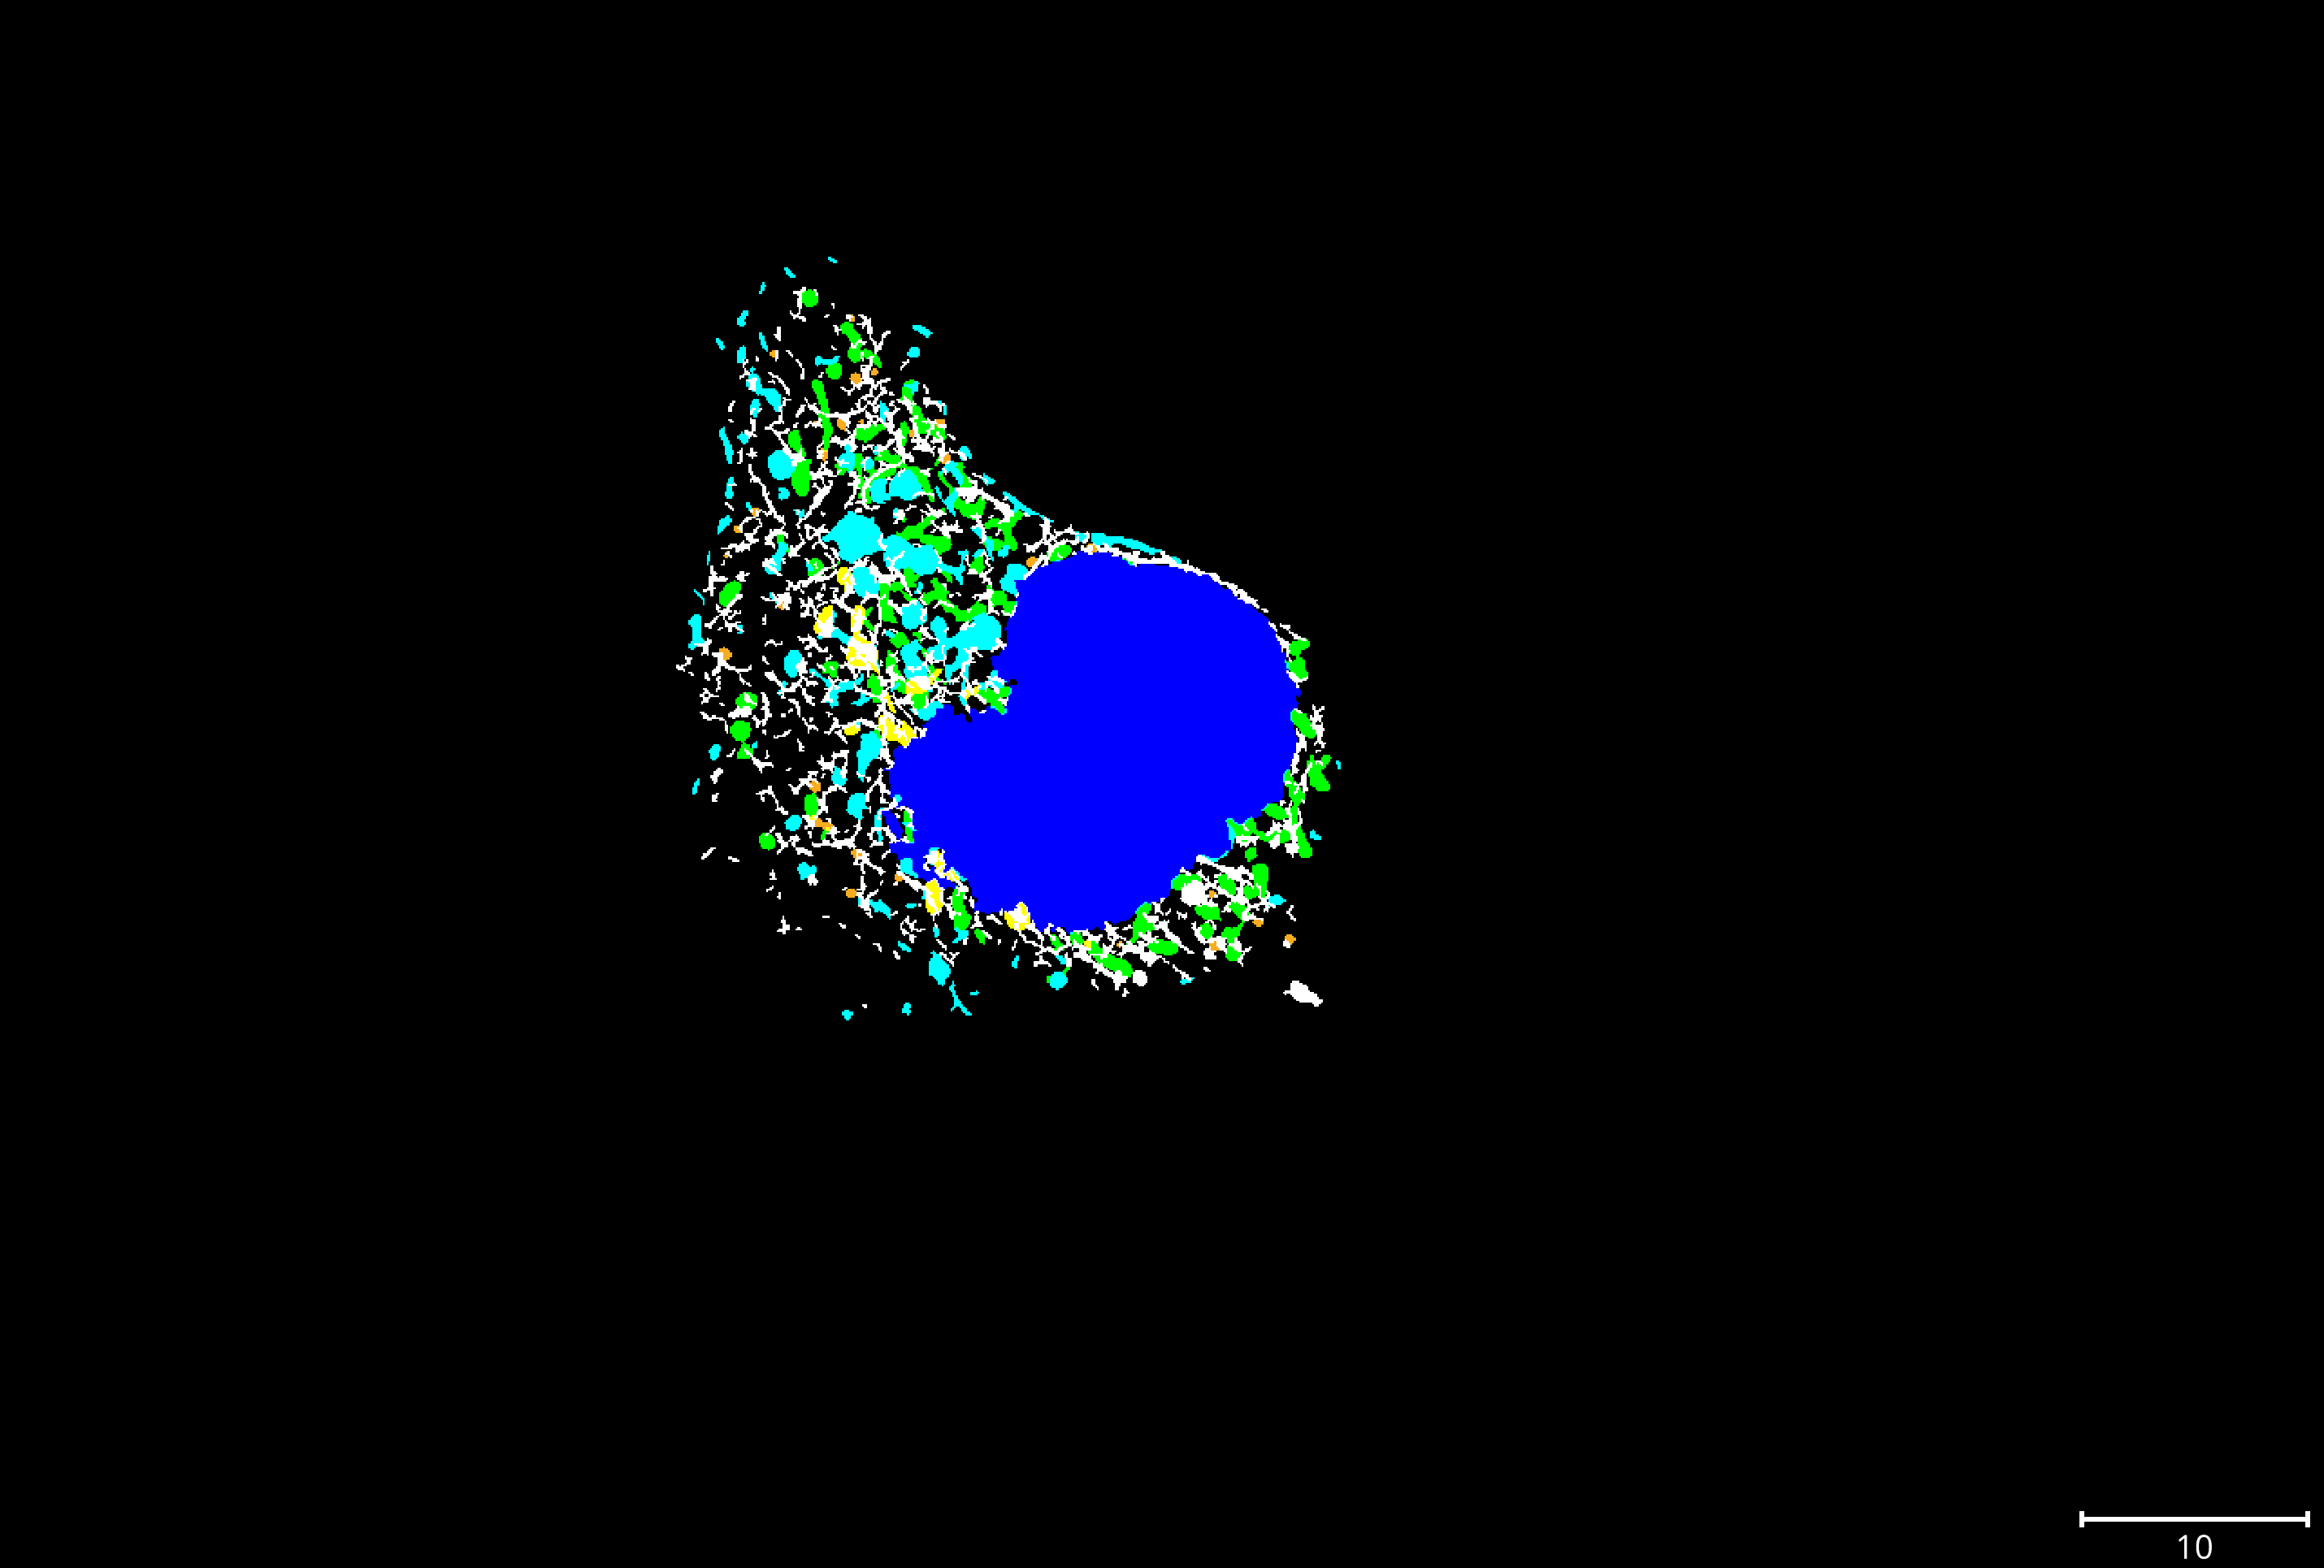

In [15]:
viewer.scale_bar.visible = True
from napari.utils.notebook_display import nbscreenshot

# viewer.dims.ndisplay = 3
# viewer.camera.angles = (-30, 25, 120)
nbscreenshot(viewer, canvas_only=True)

In [ ]:
viewer.close()


There may be a bug where the input images to the "infer_*" functions are modified in place and we might need to access them.  _MASKING_ seems to be the problem.  Also need to be clear about _when_ to apply the mask.

In [31]:
from infer_subc_2d.core.img import select_z_from_raw
###########
# infer organelles
##########
def _fixed_infer_organelles(img_data):
    """
    wrapper to infer all organelles from a single multi-channel image
    """
    # ch_to_agg = (LYSO_CH, MITO_CH, GOLGI_CH, PEROX_CH, ER_CH, LD_CH)

    # nuc_ch = NUC_CH
    # optimal_Z = find_optimal_Z(img_data, nuc_ch, ch_to_agg)
    # # Stage 1:  nuclei, cellmask, cytosol
    # img_2D = select_z_from_raw(img_data, optimal_Z)
    img_2D = fixed_get_optimal_Z_image(img_data)

    soma_mask = fixed_infer_cellmask_fromaggr(img_2D)

    nuclei_object = fixed_infer_nuclei(img_2D, soma_mask)

    cytoplasm_mask = infer_cytoplasm(nuclei_object, soma_mask)

    # cyto masked objects.
    lyso_object = fixed_infer_lyso(img_2D, cytoplasm_mask)
    mito_object = fixed_infer_mito(img_2D, cytoplasm_mask)
    golgi_object = fixed_infer_golgi(img_2D, cytoplasm_mask)
    peroxi_object = fixed_infer_perox(img_2D, cytoplasm_mask)
    er_object = fixed_infer_ER(img_2D, cytoplasm_mask)
    LD_object = fixed_infer_LD(img_2D, cytoplasm_mask)

    img_layers = [
        nuclei_object,
        lyso_object,
        mito_object,
        golgi_object,
        peroxi_object,
        er_object,
        LD_object,
        soma_mask,
        cytoplasm_mask,
    ]

    layer_names = [
        "nuclei",
        "lysosome",
        "mitochondria",
        "golgi",
        "peroxisome",
        "er",
        "LD_body",
        "soma_mask",
        "cytoplasm_mask",
    ]
    # TODO: pack outputs into something napari readable
    img_out = np.stack(img_layers, axis=0)
    return (img_out, layer_names, optimal_Z)


In [24]:

def stack_organelle_objects(soma_mask,
                            nuclei_object,
                            cytoplasm_mask,
                            lyso_object,
                            mito_object,
                            golgi_object,
                            peroxi_object,
                            er_object,
                            LD_object) -> np.ndarray:
    """ wrapper to stack the inferred objects into a single numpy.ndimage """
    img_layers = [soma_mask,
                            nuclei_object,
                            cytoplasm_mask,
                            lyso_object,
                            mito_object,
                            golgi_object,
                            peroxi_object,
                            er_object,
                            LD_object]
    return np.stack(img_layers, axis=0) 

In [20]:
def stack_organelle_layers(*layers) -> np.ndarray:
    """ wrapper to stack the inferred objects into a single numpy.ndimage """

    return np.stack(layers, axis=0) 

In [25]:
stacked_organelle_objects(*img_layers).shape

(9, 1, 768, 768)

In [32]:

inferred_organelles, layer_names, optimal_Z = _fixed_infer_organelles(img_data)


choosing _optimal_ z-slice::: 8


In [18]:
viewer = napari.Viewer()


In [19]:
cmaps = ['blue','cyan','green','yellow','bop orange','magenta','gray','gray','gray']

for i,organelle in enumerate(inferred_organelles):
    viewer.add_image(
        organelle,
        scale=scale,
        blending='additive',
        name = layer_names[i],
        colormap=cmaps[i]
    )


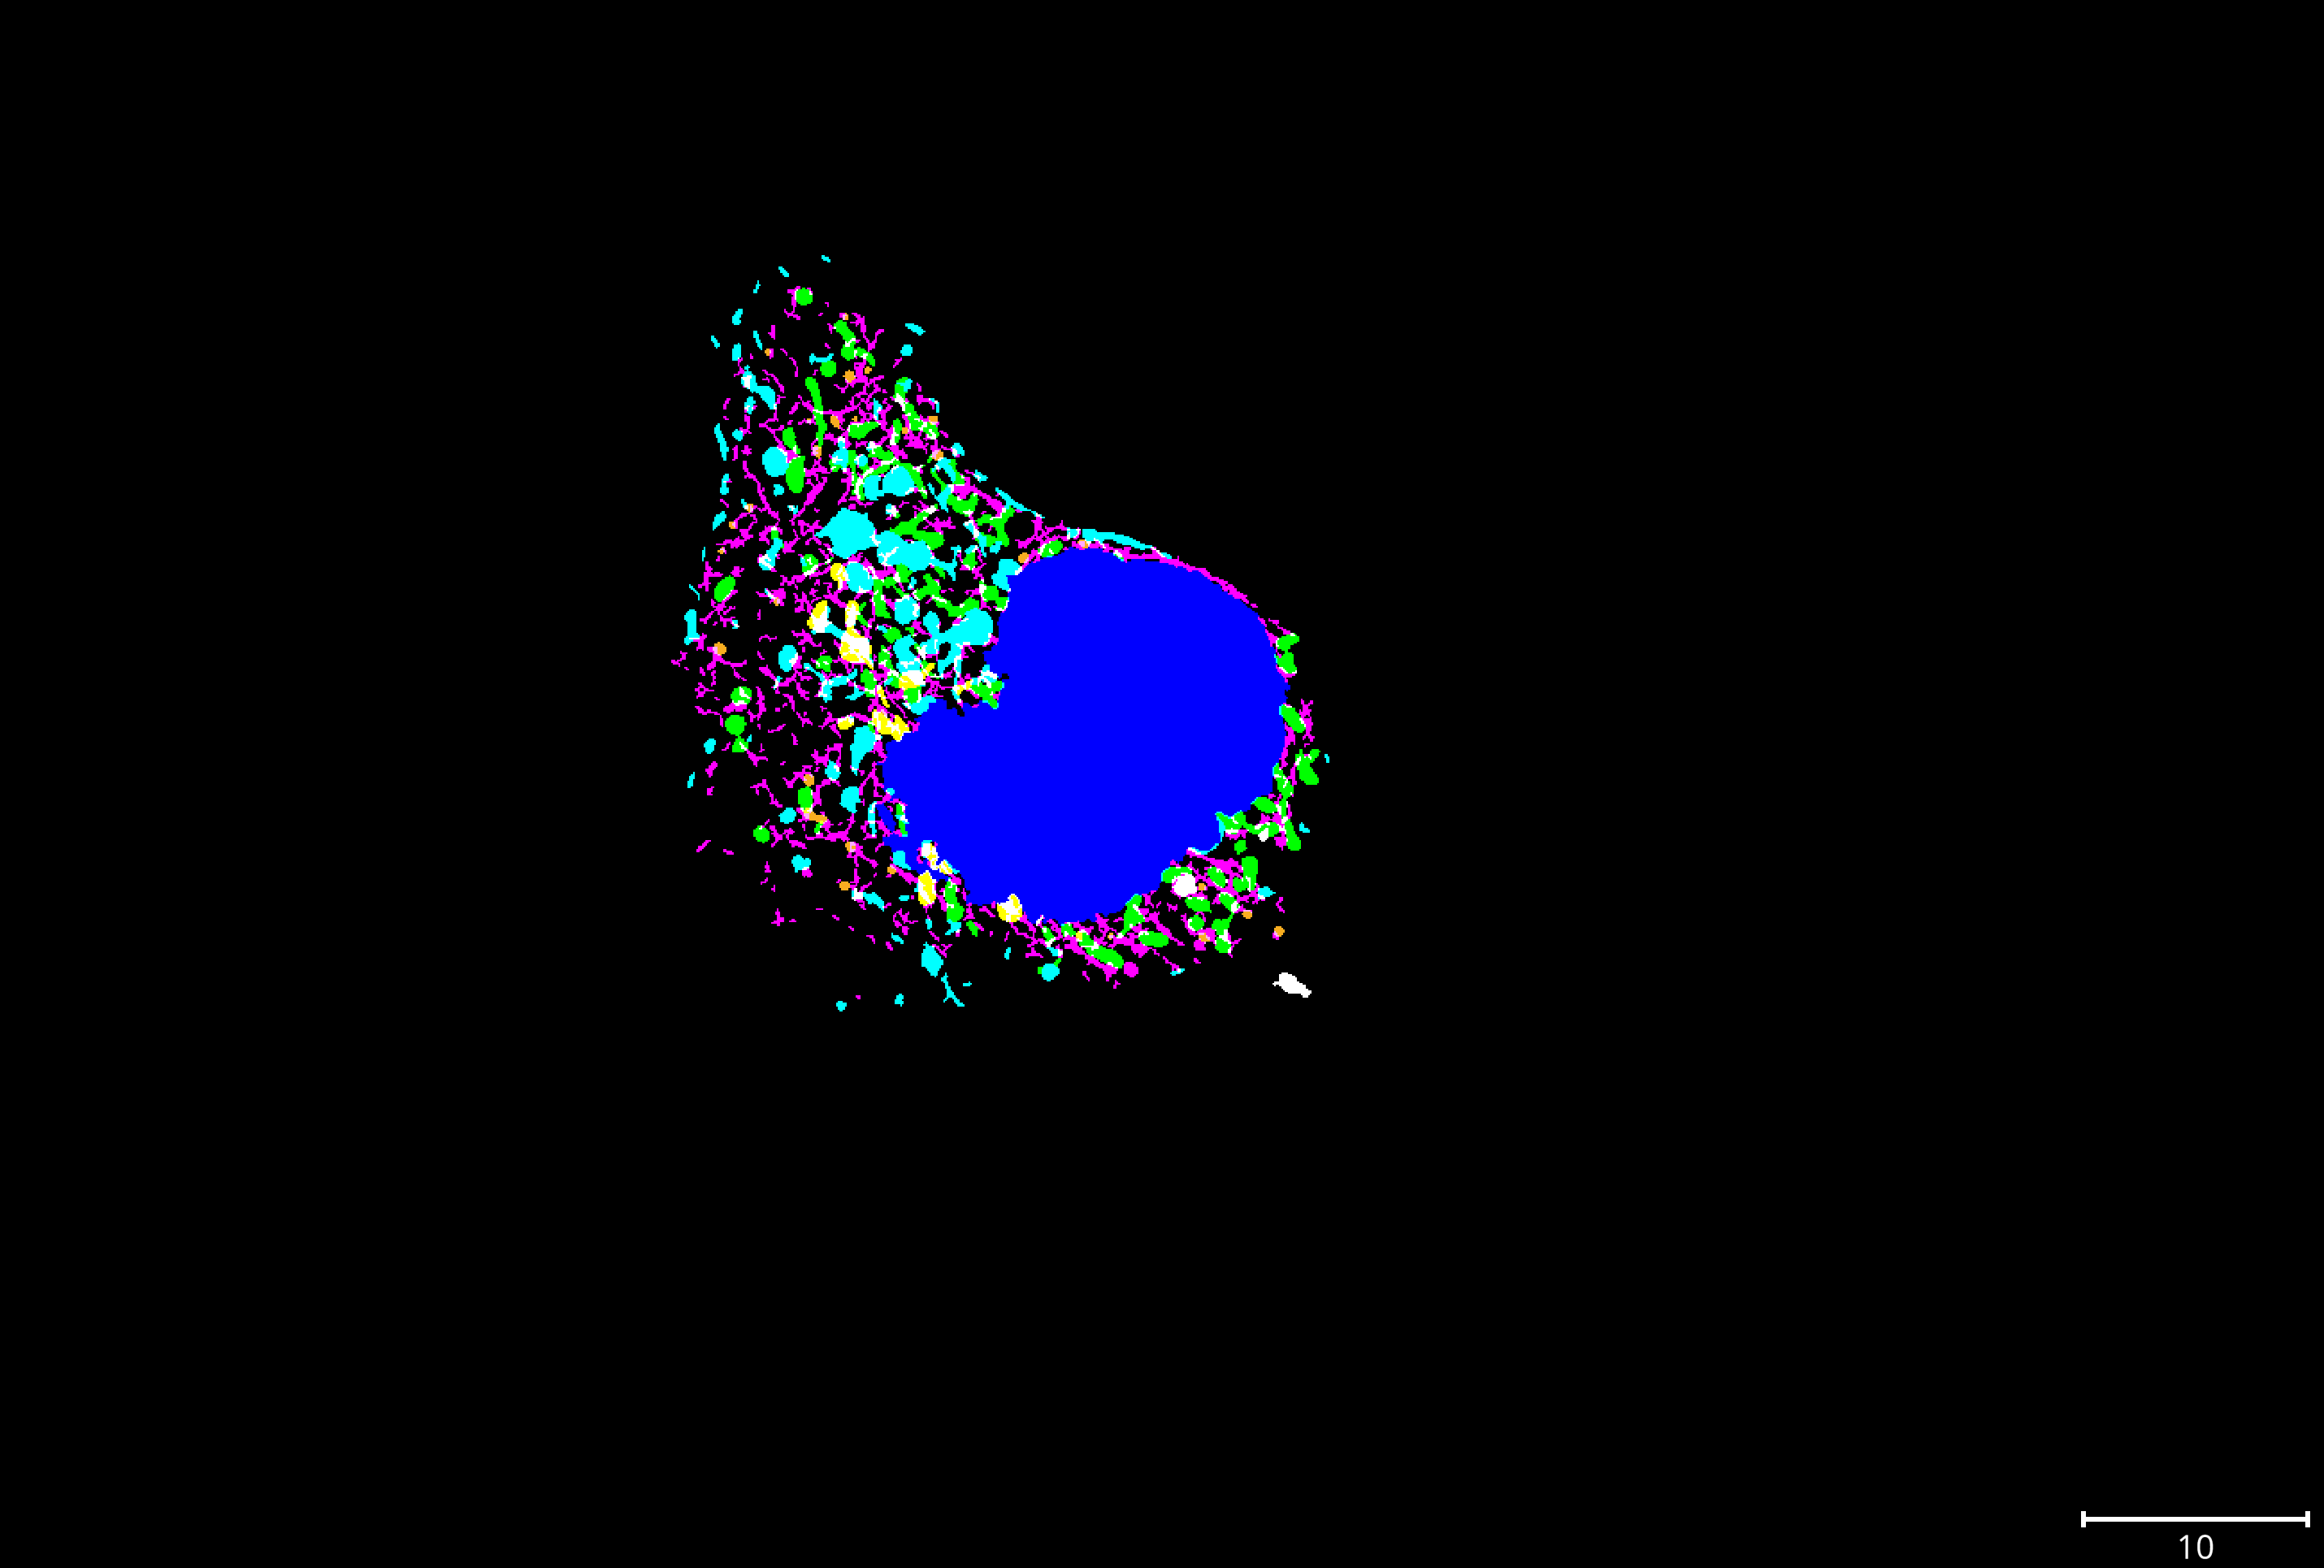

In [20]:
viewer.scale_bar.visible = True

nbscreenshot(viewer, canvas_only=True)

In [57]:
meta_dict

{'name': ['0 :: None :: Nuclei_Jan22',
  '0 :: None :: Lyso+405_Jan22',
  '0 :: None :: Mito+405_Jan22',
  '0 :: None :: Golgi+405_Jan22',
  '0 :: None :: Peroxy+405_Jan22',
  '0 :: None :: ER+405_Jan22',
  '0 :: None :: BODIPY+405low_Jan22',
  '0 :: None :: Residuals'],
 'channel_axis': 0,
 'scale': (0.5804527163320905, 0.07987165184837318, 0.07987165184837318),
 'metadata': {'aicsimage': <AICSImage [Reader: CziReader, Image-is-in-Memory: False]>,
  'raw_image_metadata': <Element 'ImageDocument' at 0x14a9c1360>},
 'file_name': '/Users/ahenrie/Projects/Imaging/data/raw/ZSTACK_PBTOhNGN2hiPSCs_BR3_N04_Unmixed.czi'}

In [21]:

##################
# export
##################

def _export_infer_organelles(img_out, layer_names, meta_dict, data_root_path):
       # get some top-level info about the RAW data
    # channel_names = meta_dict['name']
    # img = meta_dict['metadata']['aicsimage']
    # scale = meta_dict['scale']
    # channel_axis = meta_dict['channel_axis']
    img_name = meta_dict['file_name']
    # add params to metadata
    meta_dict['layer_names'] = layer_names
    out_path = data_root_path / "inferred_objects" 
    img_name_out = 'binarized_' + img_name.split("/")[-1].split(".")[0]

    out_file_n = export_ome_tiff(img_out, meta_dict, img_name_out, str(out_path)+"/", layer_names)
    print(f"saved file: {out_file_n}")
    return out_file_n

out_file_n = _export_infer_organelles(inferred_organelles, layer_names, meta_dict, data_root_path)



The default XML parser will be changing from 'xmlschema' to 'lxml' in version 0.4.0.  To silence this warning, please provide the `parser` argument, specifying either 'lxml' (to opt into the new behavior), or'xmlschema' (to retain the old behavior).


saved file: /Users/ahenrie/Projects/Imaging/data/inferred_objects/binarized_ZSTACK_PBTOhNGN2hiPSCs_BR3_N04_Unmixed.ome.tiff


In [26]:
out_file_n

'/Users/ahenrie/Projects/Imaging/data/inferred_objects/binarized_ZSTACK_PBTOhNGN2hiPSCs_BR3_N04_Unmixed.ome.tiff'

----------------------

run a batch of ALL the images

First get all the images

In [27]:
# build the datapath
# all the imaging data goes here.
data_root_path = Path(os.path.expanduser("~")) / "Projects/Imaging/data"



now build a function to loop over them all and export




In [28]:

def batch_process_all_czi(data_root_path):

    # linearly unmixed ".czi" files are here
    data_path = data_root_path / "raw"
    im_type = ".czi"
    # get the list of all files
    img_file_list = list_image_files(data_path,im_type)
    files_generated = []
    for czi_file in img_file_list:
        out_fn = process_czi_image(czi_file)
        files_generated.append(out_fn)

    print(f"generated {len(files_generated)} ")
    return files_generated

def process_czi_image(czi_file_name):
    """wrapper for processing"""

    img_data,meta_dict = read_czi_image(czi_file_name)
    # # get some top-level info about the RAW data
    # channel_names = meta_dict['name']
    # img = meta_dict['metadata']['aicsimage']
    # scale = meta_dict['scale']
    # channel_axis = meta_dict['channel_axis']

    inferred_organelles, layer_names,optimal_Z = _infer_organelles(img_data)
    meta_dict['z_slice'] = optimal_Z
    out_file_n = _export_infer_organelles(inferred_organelles, layer_names, meta_dict, data_root_path)

    ## TODO:  collect stats... 

    return out_file_n


In [25]:
output_tiffs = batch_process_all_czi(data_root_path)


choosing _optimal_ z-slice::: 12
saved file: /Users/ahenrie/Projects/Imaging/data/inferred_objects/binarized_ZSTACK_PBTOhNGN2hiPSCs_BR3_N08_Unmixed.ome.tiff
choosing _optimal_ z-slice::: 17
saved file: /Users/ahenrie/Projects/Imaging/data/inferred_objects/binarized_ZSTACK_PBTOhNGN2hiPSCs_BR1_N16_Unmixed.ome.tiff
choosing _optimal_ z-slice::: 16
saved file: /Users/ahenrie/Projects/Imaging/data/inferred_objects/binarized_ZSTACK_PBTOhNGN2hiPSCs_BR2_N02_Unmixed.ome.tiff
choosing _optimal_ z-slice::: 10
saved file: /Users/ahenrie/Projects/Imaging/data/inferred_objects/binarized_ZSTACK_PBTOhNGN2hiPSCs_BR3_N14_Unmixed.ome.tiff
choosing _optimal_ z-slice::: 10
saved file: /Users/ahenrie/Projects/Imaging/data/inferred_objects/binarized_ZSTACK_PBTOhNGN2hiPSCs_BR3_N01_Unmixed.ome.tiff
choosing _optimal_ z-slice::: 8
saved file: /Users/ahenrie/Projects/Imaging/data/inferred_objects/binarized_ZSTACK_PBTOhNGN2hiPSCs_BR3_N04_Unmixed.ome.tiff
choosing _optimal_ z-slice::: 10
saved file: /Users/ahenrie

Write the `infer_cellmask_fromaggr` spec to the widget json

In [27]:
from infer_subc_2d.organelles_config.helper import add_function_spec_to_widget_json

_fixed_infer_organelles =  {
        "name": "infer all organelles (fixed parameters)",
        "python::module": "infer_subc_2d.batch.batch_process",
        "python::function": "fixed_infer_organelles",
        "parameters": None
        }

add_function_spec_to_widget_json("fixed_infer_organelles",_fixed_infer_organelles)

function fixed_infer_organelles is already in all_functions.json


0

In [28]:

_stack_organelle_objects =  {
        "name": "stack organelles, argv spelled out",
        "python::module": "infer_subc_2d.batch",
        "python::function": "stack_organelle_objects",
        "parameters": None
        }

add_function_spec_to_widget_json("stack_organelle_objects",_stack_organelle_objects)


_stack_organelle_layers =  {
        "name": "stack organelles, *argv ",
        "python::module": "infer_subc_2d.batch",
        "python::function": "stack_organelle_layers",
        "parameters": None
        }

add_function_spec_to_widget_json("stack_organelle_layers",_stack_organelle_layers)


1

-------------------------------
## Write workflow .json
Now that we've added our function specs we can compose workflows.

In [43]:

def make_fixed_infer_organelles_batch_dict():
    """
    Procedure to infer mitochondria from linearly unmixed input from raw

    """
    step_name = []
    function_name = []
    category =[]
    parameter_values = []
    parent = []
   
    ###################
    # Stage 1:  nuclei, cellmask, cytosol
    ###################   
    step_name.append("1")
    function_name.append("fixed_get_optimal_Z_img")
    category.append("extraction")
    parameter_values.append(None)
    parent.append(0)

    step_name.append("2")
    function_name.append("fixed_infer_cellmask_fromaggr")
    category.append("core")
    parameter_values.append( None )
    parent.append(1)

    step_name.append("3")
    function_name.append("fixed_infer_nuclei")
    category.append("core")
    parameter_values.append( None )
    parent.append([1,2])

    step_name.append("4")
    function_name.append("infer_cytoplasm")
    category.append("core")
    parameter_values.append(dict(erode_nuclei = True ))
    parent.append([2,3])

    ###################
    # Stage 2:  cyto masked objects
    ###################   
    step_name.append("5")
    function_name.append("fixed_infer_lyso")
    category.append("core")
    parameter_values.append(None )
    parent.append([1,4])

    
    step_name.append("6")
    function_name.append("fixed_infer_mito")
    category.append("core")
    parameter_values.append(None)
    parent.append([1,4])

    step_name.append("7")
    function_name.append("fixed_infer_golgi")
    category.append("core")
    parameter_values.append(None)
    parent.append([1,4])

    step_name.append("8")
    function_name.append("fixed_infer_perox")
    category.append("core")
    parameter_values.append(None)
    parent.append([1,4])

    step_name.append("9")
    function_name.append("fixed_infer_er") 
    category.append("core")
    parameter_values.append(None)
    parent.append([1,4])

    step_name.append("10")
    function_name.append("fixed_infer_LD") 
    category.append("core")
    parameter_values.append(None)
    parent.append([1,4])

    step_name.append("11")
    function_name.append("stack_organelle_objects") 
    category.append("postprocessing")
    parameter_values.append(None)
    parent.append([2,3,4,5,6,7,8,9,10])


    # TODO: add export functions

    out_dict = dict()
    for i,stepn in enumerate(step_name):
        entry = dict(category=category[i],
                            function=function_name[i],
                            parameter_values=parameter_values[i],
                            parent=parent[i]
        )
        if entry['parameter_values'] is None:
            _ = entry.pop('parameter_values')
        out_dict[stepn] = entry
    
    return out_dict



In [44]:
from infer_subc_2d.organelles_config.helper import write_workflow_json

infer_fixed_infer_organelles_batch_dict = make_fixed_infer_organelles_batch_dict()

write_workflow_json("infer_fixed_infer_organelles_batch", infer_fixed_infer_organelles_batch_dict)

PosixPath('/Users/ahenrie/Projects/Imaging/infer-subc-2D/infer_subc_2d/organelles_config/conf_infer_fixed_infer_organelles_batch.json')

In [45]:

def make_fixed_infer_organelles_batch_dict2():
    """
    Procedure to infer mitochondria from linearly unmixed input from raw
    """
    
    step_name = []
    function_name = []
    category =[]
    parameter_values = []
    parent = []
   
    ###################
    # Stage 1:  nuclei, cellmask, cytosol
    ###################   
    step_name.append("1")
    function_name.append("fixed_get_optimal_Z_img")
    category.append("extraction")
    parameter_values.append(None)
    parent.append(0)

    step_name.append("2")
    function_name.append("fixed_infer_cellmask_fromaggr")
    category.append("core")
    parameter_values.append( None )
    parent.append(1)

    step_name.append("3")
    function_name.append("fixed_infer_nuclei")
    category.append("core")
    parameter_values.append( None )
    parent.append([1,2])

    step_name.append("4")
    function_name.append("infer_cytoplasm")
    category.append("core")
    parameter_values.append(dict(erode_nuclei = True ))
    parent.append([2,3])

    ###################
    # Stage 2:  cyto masked objects
    ###################   
    step_name.append("5")
    function_name.append("fixed_infer_lyso")
    category.append("core")
    parameter_values.append(None )
    parent.append([1,4])

    
    step_name.append("6")
    function_name.append("fixed_infer_mito")
    category.append("core")
    parameter_values.append(None)
    parent.append([1,4])

    step_name.append("7")
    function_name.append("fixed_infer_golgi")
    category.append("core")
    parameter_values.append(None)
    parent.append([1,4])

    step_name.append("8")
    function_name.append("fixed_infer_perox")
    category.append("core")
    parameter_values.append(None)
    parent.append([1,4])

    step_name.append("9")
    function_name.append("fixed_infer_er") 
    category.append("core")
    parameter_values.append(None)
    parent.append([1,4])

    step_name.append("10")
    function_name.append("fixed_infer_LD") 
    category.append("core")
    parameter_values.append(None)
    parent.append([1,4])


    step_name.append("11")
    function_name.append("stack_organelle_objects") 
    category.append("postprocessing")
    parameter_values.append(None)
    parent.append([2,3,4,5,6,7,8,9,10])

    # TODO: add export functions

    out_dict = dict()
    for i,stepn in enumerate(step_name):
        entry = dict(category=category[i],
                            function=function_name[i],
                            parameter_values=parameter_values[i],
                            parent=parent[i]
        )
        if entry['parameter_values'] is None:
            _ = entry.pop('parameter_values')
        out_dict[stepn] = entry
    
    return out_dict



In [46]:
from infer_subc_2d.organelles_config.helper import write_workflow_json

infer_fixed_infer_organelles_batch_dict2 = make_fixed_infer_organelles_batch_dict2()

write_workflow_json("infer_fixed_infer_organelles_batch2", infer_fixed_infer_organelles_batch_dict2)

PosixPath('/Users/ahenrie/Projects/Imaging/infer-subc-2D/infer_subc_2d/organelles_config/conf_infer_fixed_infer_organelles_batch2.json')

In [47]:
#TODO: make infer_organelles function with the exhaustive list of parmaters
_infer_organelles =  {
        "name": "Infer Endoplasmic Reticulum",
        "python::module": "infer_subc_2d.organelles",
        "python::function": "infer_ER",
        "parameters": {
                "filament_scale": {
                        "data_type": "float",
                        "increment": 0.05,
                        "max": 10,
                        "min": 0,
                        "widget_type": "slider"
                },
                "filament_cut": {
                        "data_type": "float",
                        "increment": 0.001,
                        "max": 0.5,
                        "min": 0,
                        "widget_type": "slider"
                },
                "small_obj_w": {
                        "data_type": "int",
                        "increment": 1,
                        "max": 50,
                        "min": 1,
                        "widget_type": "slider"
                }
        }
}

add_function_spec_to_widget_json("eeeinfer_organelles", _infer_organelles, overwrite=True )



1

35 files processed in 6 minutes 47 seconds!!

In [29]:

tiff_img_data,tiff_meta_dict = read_czi_image(output_tiffs[-1])


In [30]:
tiff_img_data.shape

img = tiff_meta_dict['metadata']['aicsimage']
img.dims

<Dimensions [T: 1, C: 9, Z: 1, Y: 768, X: 768]>

In [ ]:
from aicsimageio.writers import OmeTiffWriter
data_in = img_out
channel_names = [layer_names]
image_names = [img_name]
print(image_names)
# chan_names = meta_in['metadata']['aicsimage'].channel_names
dimension_order = ["CZYX"]

num_images = len(  [data_in.shape])
if data_in.dtype == "bool":
    data_in = data_in.astype(np.uint8)
    data_in[data_in > 0] = 255

physical_pixel_sizes = [meta_dict["metadata"]["aicsimage"].physical_pixel_sizes]
out_ome = OmeTiffWriter.build_ome(
        [data_in.shape],
        [data_in.dtype],
        channel_names=channel_names,  # type: ignore
        image_name=image_names,
        physical_pixel_sizes=physical_pixel_sizes,
        dimension_order=dimension_order,
    )